# ANALYSIS OF HOUSING BUSINESS OPPORTUNITY IN JAKARTA

### This notebook is for Capstone Project week 2.

#### Description of the notebook
This project will extract and process the data to analyze the housing business opportunity in Jakarta.
The data of districts and subdistricts of DKI Jakarta is scarped from wikipedia and geopy library is used to obtain its corodinate.
Then the foursquare API is used to extract the residential venues.

#### Load the necessary library

In [1]:
# Libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
!pip install folium
import folium

# data scrapping tool
from bs4 import BeautifulSoup

from urllib.request import urlopen

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Teresa\anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  conda                                4.9.0-py38h9bdc248_1 --> 4.9.2-py38haa244fe_0




conda-4.9.2          | 3.1 MB    |            |   0% 
conda-4.9.2          | 3.1 MB    | ####5      |  45% 
conda-4.9.2          | 3.1 MB    | ########## | 100% 
conda-4.9.2          | 3.1 MB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Libraries imported.


#### Population density of each region in DKI Jakarta

In [38]:
# Population density of each region obtained from wikipedia data from census held in 2017
# https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta

Region = ['Jakarta Pusat','Jakarta Utara','Jakarta Timur','Jakarta Selatan','Jakarta Barat'];
Pop_dens = [21732.46, 12225.06, 16116.55, 14181.29, 18676.64];

# create data frame
population_density = pd.DataFrame({"Region":Region, "Population Density":Pop_dens})
population_density

,Region,Population Density
0,Jakarta Pusat,21732.46
1,Jakarta Utara,12225.06
2,Jakarta Timur,16116.55
3,Jakarta Selatan,14181.29
4,Jakarta Barat,18676.64


([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

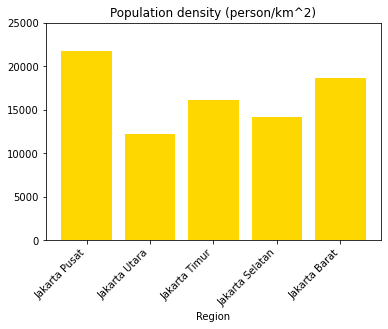

In [83]:
# plot the population density
plt.bar(population_density.Region, population_density["Population Density"], color='gold')
plt.xlabel('Region')
plt.ylim(0,25000)
plt.title('Population density (person/km^2)')
plt.xticks(ha='right', rotation=45)

#### Number of household of each region in DKI Jakarta

In [96]:
# Number of household in thousand

Region = ['Jakarta Pusat','Jakarta Utara','Jakarta Timur','Jakarta Selatan','Jakarta Barat'];
household_thousand = [241.62, 477.50, 747.59, 580.45, 682.34];

household_number = pd.DataFrame({"Region":Region, "Household (thousand)":household_thousand})
household_number

,Region,Household (thousand)
0,Jakarta Pusat,241.62
1,Jakarta Utara,477.50
2,Jakarta Timur,747.59
3,Jakarta Selatan,580.45
4,Jakarta Barat,682.34


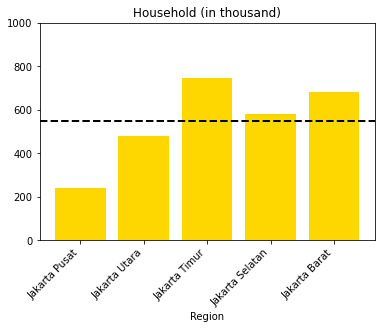

In [99]:
# plot the number of household
plt.bar(household_number.Region, household_number["Household (thousand)"], color='gold')
plt.xlabel('Region')
plt.ylim(0,1000)
plt.title('Household (in thousand)')
plt.xticks(ha='right', rotation=45)
plt.axhline(household_number['Household (thousand)'].mean(), color='k', linestyle='--', linewidth=2)

#### Scrap the data of distric and subdistrict from the wikipedia

In [2]:
# data source
url = 'https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta'

# open url
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [3]:
# find the table
tables = soup.find_all('table',{'class':'wikitable sortable'})

In [4]:
# find regions in Jakarta city
jakarta_regions = []

# Based on apriori knowledge, we know that Jakarta has 6 regions including Kepulauan Seribu.
# For the sake of simplicity, we will only consider 5 regions that are located in the mainland.
# Extract the name of the region from the website
for n_regions in range(1,6):
    region_name = soup.find_all('h2')[n_regions].text
    # cleaning the text
    region_name = region_name.replace('Kota Administrasi ','')
    region_name = region_name.replace('[sunting | sunting sumber]','')
    # append the new region name to the list
    jakarta_regions.append(region_name)

# show the list
jakarta_regions

['Jakarta Pusat',
 'Jakarta Utara',
 'Jakarta Timur',
 'Jakarta Selatan',
 'Jakarta Barat']

In [5]:
# create an empty data frame to store the value
Jakarta = pd.DataFrame({"Region":[], "District":[], "SubDistrict":[]})

# loop through all table and collect the information needed
for i,table in enumerate(tables[1:-1]):
    body = table.find('tbody')                                # load the body of the table
    region = jakarta_regions[i]                               # call the region name associated with the table
    for row in body.find_all('tr')[1:-1]:                     # loop through each row
        items = row.find_all('td')                            # find items in each column
        district_name = items[1].a.text                       # district name is located in 2nd column
        subdist_names = items[3].text.split('\n')             # subdistrict name is located in 4th column
        while("" in subdist_names): subdist_names.remove("")  # split the resulting text
        for subdist_name in subdist_names:                    # create new data entry based on subdistrict
            new_row = {"Region":region, "District":district_name, "SubDistrict":subdist_name}
            Jakarta = Jakarta.append(new_row, ignore_index=True)
Jakarta

,Region,District,SubDistrict
0,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat
1,Jakarta Pusat,Cempaka Putih,Cempaka Putih Timur
2,Jakarta Pusat,Cempaka Putih,Rawasari
3,Jakarta Pusat,Gambir,Cideng
4,Jakarta Pusat,Gambir,Duri Pulo
5,Jakarta Pusat,Gambir,Gambir
6,Jakarta Pusat,Gambir,Kebon Kelapa
7,Jakarta Pusat,Gambir,Petojo Selatan
8,Jakarta Pusat,Gambir,Petojo Utara
9,Jakarta Pusat,Johar Baru,Galur


In [6]:
# Check if there is duplicate on the Subdistrict data.
list_subdistrict = Jakarta['SubDistrict'].to_list()
if any(list_subdistrict.count(element) == 1 for element in list_subdistrict):
    print("There is no duplicate on subdistrict name")
if any(list_subdistrict.count(element) > 1 for element in list_subdistrict):
    print("There is duplicate on subdistrict name. Please double check the result in previous step.")

There is no duplicate on subdistrict name


Find coordinate of each district

In [7]:
# define geolocator agent object
geolocator = Nominatim(user_agent="jakarta_explorer")

# create function to extract latitude and longitude from geopy geocoding
def extractcoordinate(df):
    # initialize data frame to store the value
    coordinate_df = pd.DataFrame({"SubDistrict":[], "Latitude":[], "Longitude":[]})
    # loop through each row in the input data frame
    for index, row in df.iterrows():
        subdistrict = row["SubDistrict"]
        district = row["District"]
        region = row["Region"]
        location = geolocator.geocode(subdistrict + ", " + district + ", " + region + ", Jakarta, Indonesia", timeout=10)
        if location is None:
            new_data = {"SubDistrict": subdistrict,"Latitude": float("NaN"),"Longitude": float("NaN")}
        if location is not None:
            new_data = {"SubDistrict": subdistrict,"Latitude": location.latitude,"Longitude": location.longitude}
        coordinate_df = coordinate_df.append(new_data, ignore_index=True)
    return coordinate_df

# find the coordinate of each district using the function defined in the previous step
coord_district = extractcoordinate(Jakarta)
coord_district

,SubDistrict,Latitude,Longitude
0,Cempaka Putih Barat,-6.178733,106.862485
1,Cempaka Putih Timur,-6.177633,106.870449
2,Rawasari,-6.190680,106.866450
3,Cideng,-6.174860,106.809150
4,Duri Pulo,-6.161660,106.808114
5,Gambir,-6.176684,106.830653
6,Kebon Kelapa,-6.163507,106.824466
7,Petojo Selatan,-6.174801,106.816405
8,Petojo Utara,-6.165107,106.815411
9,Galur,-6.176146,106.855072


In [8]:
# merge the dataframe to the dataframe containing regions and district of Jakarta
Jakarta = pd.merge(Jakarta,coord_district, on='SubDistrict')
Jakarta

,Region,District,SubDistrict,Latitude,Longitude
0,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,-6.178733,106.862485
1,Jakarta Pusat,Cempaka Putih,Cempaka Putih Timur,-6.177633,106.870449
2,Jakarta Pusat,Cempaka Putih,Rawasari,-6.190680,106.866450
3,Jakarta Pusat,Gambir,Cideng,-6.174860,106.809150
4,Jakarta Pusat,Gambir,Duri Pulo,-6.161660,106.808114
5,Jakarta Pusat,Gambir,Gambir,-6.176684,106.830653
6,Jakarta Pusat,Gambir,Kebon Kelapa,-6.163507,106.824466
7,Jakarta Pusat,Gambir,Petojo Selatan,-6.174801,106.816405
8,Jakarta Pusat,Gambir,Petojo Utara,-6.165107,106.815411
9,Jakarta Pusat,Johar Baru,Galur,-6.176146,106.855072


In [9]:
# Check for empty values
print("Number of subdistrict with no information of coordinate is ", \
      Jakarta["Latitude"].isna().sum())

Number of subdistrict with no information of coordinate is  1


In [10]:
# delete district whose coordinate is empty
Jakarta = Jakarta[Jakarta['Latitude'].notna()]
Jakarta.reset_index(drop=True)

,Region,District,SubDistrict,Latitude,Longitude
0,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,-6.178733,106.862485
1,Jakarta Pusat,Cempaka Putih,Cempaka Putih Timur,-6.177633,106.870449
2,Jakarta Pusat,Cempaka Putih,Rawasari,-6.190680,106.866450
3,Jakarta Pusat,Gambir,Cideng,-6.174860,106.809150
4,Jakarta Pusat,Gambir,Duri Pulo,-6.161660,106.808114
5,Jakarta Pusat,Gambir,Gambir,-6.176684,106.830653
6,Jakarta Pusat,Gambir,Kebon Kelapa,-6.163507,106.824466
7,Jakarta Pusat,Gambir,Petojo Selatan,-6.174801,106.816405
8,Jakarta Pusat,Gambir,Petojo Utara,-6.165107,106.815411
9,Jakarta Pusat,Johar Baru,Galur,-6.176146,106.855072


Use geopy library to get the latitude and longitude values of Jakarta province. This coordinate will be use to center the map at Jakarta.

In [11]:
# find the coordinate of Jakarta
address = 'Jakarta, Indonesia'
geolocator = Nominatim(user_agent="jakarta_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

Create a map of Jakarta with district superimposed on top

In [12]:
# load the map of Jakarta
map_jakarta = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers of the location of each district to the map
for region, district, subdist, lat, lng in zip(Jakarta['Region'], Jakarta['District'], Jakarta['SubDistrict'],\
                                      Jakarta['Latitude'],Jakarta['Longitude']):
    label = '{},{},{}'.format(subdist,district, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  

# show the map
map_jakarta

#### Extract residential venues around the subdistrict coordinate using Foursquare

In [13]:
# @hidden_cell
# Define Foursquare Credentials and Version
# This cell is hidden

CLIENT_ID = 'VMULRHCK0HCSBJCQY13YYALFWYD44RYCYTI5FE1DB0UGDHFM' # your Foursquare ID
CLIENT_SECRET = 'LO4EZRECGAWVYID03VYKABFNQFSHASRII1D1YPS4XIAKAHMI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

For each district, get the venues within a radius of 2 km

In [14]:
# create the function to obtain venues in each neighbourhoods
# extract its category, and structure it into pandas dataframe

def getResidence(names, latitudes, longitudes, radius=2000):
    HOUSE_CAT_ID = "4e67e38e036454776db1fb3a" # Category_id for venue served as residence
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            HOUSE_CAT_ID)
            
        # make the GET request, return failed flag if no venues found
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except Exeption as e:
                print("Failed")
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name,
                lat,
                lng,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
        except:
                print("Venue not found")

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['SubDistrict', 
                  'SubDistrict Latitude', 
                  'SubDistrict Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# obtain venues in each district
# extract its category, and structure it into pandas dataframe
jakarta_residences = getResidence(names=Jakarta['SubDistrict'],
                                   latitudes=Jakarta['Latitude'],
                                   longitudes=Jakarta['Longitude']
                                  )
print('House location extraction done!')

Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
Venue not found
House location extraction done!


#### Data cleaning
Remove the duplicate and show the list of residential building found using the function above.

In [100]:
# drop duplicates and show the venues
jakarta_residences = jakarta_residences.drop_duplicates().reset_index(drop=True)
jakarta_residences

,SubDistrict,SubDistrict Latitude,SubDistrict Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cempaka Putih Barat,-6.178733,106.862485,Sentosa Residence Jakarta™,-6.176731,106.864743,Residential Building (Apartment / Condo)
1,Cempaka Putih Barat,-6.178733,106.862485,Apartment Mediterania Kemayoran,-6.178106,106.858698,Residential Building (Apartment / Condo)
2,Cempaka Putih Barat,-6.178733,106.862485,"The Green Pramuka, Tower Faggio",-6.187980,106.871143,Residential Building (Apartment / Condo)
3,Cempaka Putih Barat,-6.178733,106.862485,The Green Pramuka City,-6.188247,106.872218,Residential Building (Apartment / Condo)
4,Cempaka Putih Barat,-6.178733,106.862485,The Green Pramuka Apartment - Tower Chrysant,-6.188469,106.872447,Residential Building (Apartment / Condo)
...,...,...,...,...,...,...,...
4103,Srengseng,-6.206499,106.754106,Taman Meruya Ilir,-6.198684,106.738970,Housing Development
4104,Srengseng,-6.206499,106.754106,Permata Mediterania,-6.222047,106.762390,Housing Development
4105,Srengseng,-6.206499,106.754106,Taman Alfa Indah Dog Run,-6.224027,106.755836,Dog Run
4106,Srengseng,-6.206499,106.754106,Villa Kelapa Dua,-6.213339,106.766105,Assisted Living


The obtained venues still includes some non residential venue. Data wriggling is needed to get the venues that are residential venues.

In [32]:
np.unique(jakarta_residences["Venue Category"])

array(['Airport', 'Arcade', 'Assisted Living', 'Bakery', 'Beach',
       'Bed & Breakfast', 'Beer Garden', 'Boarding House', 'Building',
       'Bus Line', 'Business Center', 'Café', 'Church',
       'College Residence Hall', 'Coworking Space', 'Design Studio',
       'Dog Run', 'Eye Doctor', 'Field', 'Food Court', 'General Travel',
       'Golf Course', 'Grocery Store', 'Gym Pool', 'Hotel',
       'Housing Development', 'Lake', 'Mosque', 'Neighborhood',
       'Nightclub', 'Office', 'Other Great Outdoors', 'Park', 'Parking',
       'Playground', 'Pool', 'Residence',
       'Residential Building (Apartment / Condo)', 'Road',
       'Sculpture Garden', 'Shopping Mall', 'Temple', 'University',
       'Vegetarian / Vegan Restaurant'], dtype=object)

In [101]:
# remove venues that are not residential category
jakarta_residences_clean = jakarta_residences.loc[jakarta_residences['Venue Category'].isin(['Assisted Living','Boarding House','Housing Development','Neighborhood','Residence','Residential Building (Apartment / Condo)'])]
jakarta_residences_clean.reset_index(drop=True)

,SubDistrict,SubDistrict Latitude,SubDistrict Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cempaka Putih Barat,-6.178733,106.862485,Sentosa Residence Jakarta™,-6.176731,106.864743,Residential Building (Apartment / Condo)
1,Cempaka Putih Barat,-6.178733,106.862485,Apartment Mediterania Kemayoran,-6.178106,106.858698,Residential Building (Apartment / Condo)
2,Cempaka Putih Barat,-6.178733,106.862485,"The Green Pramuka, Tower Faggio",-6.187980,106.871143,Residential Building (Apartment / Condo)
3,Cempaka Putih Barat,-6.178733,106.862485,The Green Pramuka City,-6.188247,106.872218,Residential Building (Apartment / Condo)
4,Cempaka Putih Barat,-6.178733,106.862485,The Green Pramuka Apartment - Tower Chrysant,-6.188469,106.872447,Residential Building (Apartment / Condo)
...,...,...,...,...,...,...,...
3427,Srengseng,-6.206499,106.754106,Panti Asuhan Yatim Dan Dhu'Afa,-6.195976,106.742668,Housing Development
3428,Srengseng,-6.206499,106.754106,Taman Meruya Ilir,-6.198684,106.738970,Housing Development
3429,Srengseng,-6.206499,106.754106,Permata Mediterania,-6.222047,106.762390,Housing Development
3430,Srengseng,-6.206499,106.754106,Villa Kelapa Dua,-6.213339,106.766105,Assisted Living


In [35]:
# count how many venues in residential category
jakarta_residences_clean.shape[0]

3432

In [36]:
# merge the data into Jakarta data frame
Jakarta_residences_venues = pd.merge(Jakarta,jakarta_residences_clean, on='SubDistrict')
Jakarta_residences_venues.drop(columns=['Latitude','Longitude','SubDistrict Latitude','SubDistrict Longitude'])

,Region,District,SubDistrict,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,Sentosa Residence Jakarta™,-6.176731,106.864743,Residential Building (Apartment / Condo)
1,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,Apartment Mediterania Kemayoran,-6.178106,106.858698,Residential Building (Apartment / Condo)
2,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,"The Green Pramuka, Tower Faggio",-6.187980,106.871143,Residential Building (Apartment / Condo)
3,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,The Green Pramuka City,-6.188247,106.872218,Residential Building (Apartment / Condo)
4,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,The Green Pramuka Apartment - Tower Chrysant,-6.188469,106.872447,Residential Building (Apartment / Condo)
5,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,Apartemen Green Pramuka City,-6.188752,106.873083,Residential Building (Apartment / Condo)
6,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,GADING ICON CITY APARTMENT,-6.189440,106.876193,Residential Building (Apartment / Condo)
7,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,Apartemen Salemba Residence,-6.195210,106.856082,Residential Building (Apartment / Condo)
8,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,Cempaka Putih,-6.173967,106.875144,Housing Development
9,Jakarta Pusat,Cempaka Putih,Cempaka Putih Barat,Komplek Bulog,-6.188098,106.877265,Housing Development


#### Count number of residential venues for each region.

In [74]:
region_n_residential = pd.DataFrame({"Region":[], "N Residential Building":[]})

for region in jakarta_regions:
    region_venues = Jakarta_residences_venues.loc[Jakarta_residences_venues['Region'] == region]
    n_residential = region_venues.shape[0]
    new_n = {"Region":region,"N Residential Building":n_residential}
    region_n_residential = region_n_residential.append(new_n, ignore_index=True)

region_n_residential

,Region,N Residential Building
0,Jakarta Pusat,657.0
1,Jakarta Utara,429.0
2,Jakarta Timur,487.0
3,Jakarta Selatan,1055.0
4,Jakarta Barat,804.0


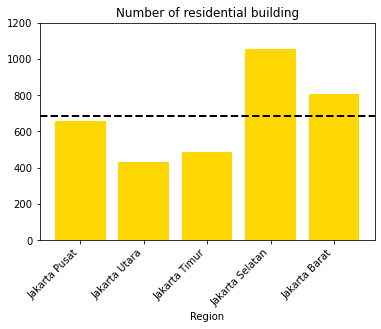

In [80]:
# plot the residential building
plt.bar(region_n_residential.Region, region_n_residential["N Residential Building"], color='gold')
plt.xlabel('Region')
plt.ylim(0,1200)
plt.title('Number of residential building')
plt.xticks(ha='right', rotation=45)
plt.axhline(region_n_residential['N Residential Building'].mean(), color='k', linestyle='--', linewidth=2)